In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
import random
from collections import defaultdict
from sklearn import metrics
from time import time
import numpy as np
import re
from nltk.corpus import stopwords
import unicodedata
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import seaborn as sns

In [17]:
# CSV "2022_Urgencia_texto_limpo.csv" with only one column, without header
# read_csv
justificativas_limpo = pd.read_csv("2022_Urgencia_texto_limpo.csv", sep=";", encoding="latin-1")

print(justificativas_limpo.columns)

justificativas_limpo.dropna(inplace=True)

list_justificativa = justificativas_limpo['justificativa_urgencia_viagem'].tolist()

print(len(list_justificativa))

Index(['justificativa_urgencia_viagem'], dtype='object')
384275


In [18]:
random.seed(42)
list_justificativa = random.sample(list_justificativa, 120000)

print(list_justificativa[:10])

['necessario aguardar confirmacao disponibilidade equipe secex participarao obrigatoriamente evento confirmacao ocorreu hoje', 'necessaria correcao pcdps cadastradas anteriormente', 'servidor substituir pro reitora afastada questoes saude', 'familiar constam cronograma departamento', 'periodo data definidos coordenacao juntamente gabinete pessoal pr', 'informo sr documentos referentes necessidade autorizacao despesas encontram anexos', 'necessidade missao', 'necessidade servico', 'acordo aumento volume trabalho deficit acentuado efetivo coordenacao gestao efetivo coge exposto nota tecnica', 'confirmada prazo legal funcao disponibilidade veiculo oficial servidor designado portaria especifica']


In [19]:
n_comp = 50

In [20]:
count_vectorizer = CountVectorizer(max_df=0.9, min_df=0.01)
X_count = count_vectorizer.fit_transform(list_justificativa)


In [21]:
# lsa_count = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
# X_count = lsa_count.fit_transform(X_count)
# explained_variance = lsa_count[0].explained_variance_ratio_.sum()

In [22]:
print(X_count.shape)

(120000, 144)


In [23]:
sample = list_justificativa
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01)
X = vectorizer.fit_transform(sample)

In [24]:
print(X.shape)

(120000, 144)


In [25]:
lsa = make_pipeline(TruncatedSVD(n_components=n_comp, random_state=42), Normalizer(copy=False))
X = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance:.2f} for {n_comp} components")

Explained variance of the SVD step: 0.65 for 50 components


In [26]:
neighbors = NearestNeighbors(n_neighbors=99, n_jobs=4)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

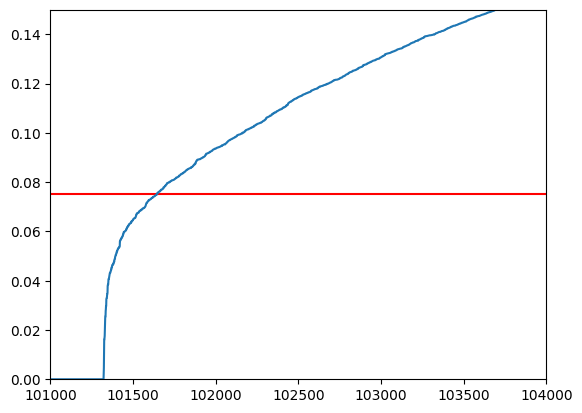

In [33]:
sorted_distances = np.sort(distances, axis=0)
items = sorted_distances[:,1]
plt.xlim([101000, 104000])
plt.ylim([0.0, 0.15])
plt.axhline(y=0.075, color='r', linestyle='-')
plt.plot(items)


# https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In [34]:
db = DBSCAN(eps=0.07, min_samples=99, algorithm='auto', n_jobs=4).fit(X)

labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 140
Estimated number of noise points: 62530


In [35]:
idx = np.argsort(db.core_sample_indices_)
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[db.core_sample_indices_[idx]] = True


def get_clustered_sentences(labels, sentences):
    clustered_sentences = defaultdict(list)
    for sentence_id, cluster_id in enumerate(labels):
        if cluster_id >= 0:
            clustered_sentences[cluster_id].append(sentences[sentence_id])
    return clustered_sentences


clustered_sentences = get_clustered_sentences(labels, sample)

print(len(clustered_sentences))
print(clustered_sentences.keys())


# for cluster_id, sentences in clustered_sentences.items():
#     print(f"Cluster {cluster_id}:")
#     print(sentences[:10])
#     print()


140
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 139, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138])


In [12]:
# 1-D swarmplot
# sns.swarmplot(x=clusters_count['phrase'], color="red")

In [36]:
for i in range(n_clusters_):
    print("Cluster %d:" % i),
    print("Cluster size: %d" % len(clustered_sentences[i]))

    set_phrases = set(clustered_sentences[i])

    for phr in random.sample(set_phrases,min(20, len(set_phrases))):
        print("  %s" % phr)
    print("\n")


Cluster 0:
Cluster size: 224
  remarcada saude servidor
  substituicao ultima hora servidor escalado problemas particulares
  troca ultima hora servidor cobertura audiovisual
  motiva indicacao servidor ocorrido
  cc temporario pediu desligamento servidor ocupa subarea
  demora servidor corrigir dado documento
  servidor ciente
  demora servidor requerimento demora assinatura documento
  substituicao servidor desligando quadro
  servidor encontra organizando prestacao contas outro
  reducao quadro servidor servidara escolida ultima hora
  servidor prestando recenseadores terras aldeias indigenas
  servidor recebeu inscricao cortesia
  cc pediu desligamento servidor ocupar temporariamente subarea
  servidor convocado
  servidor demorou requerimento solicitando
  servidor pendencia havia lancada contato servidor sergio botelho ufsm br
  conduzir servidor pierre george sousa sale silva reunioes area pombal sousa patos cg
  srh validou capacitacao servidor noite mail anexado
  mudanca plan

/tmp/ipykernel_2595/3344563523.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for phr in random.sample(set_phrases,min(20, len(set_phrases))):


In [14]:
#http://datamining.rutgers.edu/publication/internalmeasures.pdf

## Silhouette Coefficient

In [37]:
metrics.silhouette_score(X, labels, metric='euclidean', sample_size=40000, random_state=42)

0.21654852157681848

## Calinski-Harabasz Index

In [40]:
metrics.calinski_harabasz_score(X, labels)

736.2320948481619

## Davies-Bouldin Index

In [41]:
metrics.davies_bouldin_score(X, labels)

1.0024151188372297